In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import Model, ODR, RealData
from scipy.optimize import curve_fit

# First part

The students won't have to perform a fit, they will just take one of the measured lenghts with the associated period and apply the equation.

In [24]:
def t2(g, L):
    return (4*np.pi**2/g[0])*L

In [4]:
data = [
    {
        "length": 0.15,
        "periods": [0.86, 0.74, 0.74, 0.80, 0.87, 0.80]
    },
    {
        "length": 0.22,
        "periods": [1., 1., 0.87, 1., 1.]
    },
    {
        "length": 0.31,
        "periods": [1.13, 1.2, 1.19, 1.2, 1.13]
    }
]

In [16]:
lengths = [d["length"] for d in data]
lengths_err = .01 * np.ones(len(lengths))
periods = [np.mean(d["periods"]) for d in data]
periods_err = [np.std(d["periods"]) for d in data]
periods_square = [p**2 for p in periods]
periods_square_err = [(u/v)**2 for u, v in zip(periods_err, periods)]

In [29]:
#popt, pcov = curve_fit(t2, lengths, periods_square)

func = Model(t2)
dt = RealData(lengths, periods_square, sx=lengths_err, sy=periods_square_err)
odr = ODR(dt, func, beta0=[100])
out = odr.run()

xx = np.linspace(lengths[0], lengths[-1], 1000)
yy = t2(out.beta, xx)

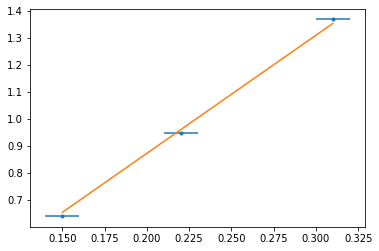

In [30]:
fig, ax = plt.subplots()
plt.errorbar(lengths, periods_square, xerr=lengths_err, yerr=periods_square_err, 
             marker='.', linestyle='');
plt.plot(xx, yy);


# Second Part

In [107]:
import pandas as pd

In [213]:
def general_damped_sinusoid(t, amp, dec, ang_freq, phase, shift):
    return amp * np.exp(-dec*t) * np.cos(ang_freq*t+phase) + shift

def time_to_rad(arr):
    """ Convert time values to radiants with a conversion: n_rad = t*step_rad*pi/step_time
        Time is in [ms]
    """
    step_rad = 0.5
    step_time = 10000
    return arr*step_rad*np.pi/step_time

In [224]:
df = pd.read_csv('raw_data.csv')

In [225]:
df.rename(columns={'Time (s)': 'time', 
                   'Linear Acceleration x (m/s^2)': 'x_acc', 
                   'Linear Acceleration y (m/s^2)': 'y_acc',
                   'Linear Acceleration z (m/s^2)': 'z_acc', 
                   'Absolute acceleration (m/s^2)': 'abs_acc'}, inplace=True)
df['time_in_rad'] = time_to_rad(df['time'])

In [226]:
df.query('time > 15', inplace=True)
df = df.iloc[::300, :]

In [231]:
#popt, pcov = curve_fit(general_damped_sinusoid, df['time_in_rad'], df['y_acc'], maxfev=100000)
popt, pcov = curve_fit(general_damped_sinusoid, df['time'], df['y_acc'], p0=[0, 0, 0, 0, 0], maxfev=100000)
x = np.linspace(min(df['time']), max(df['time']), 100)
y = general_damped_sinusoid(x, *popt)

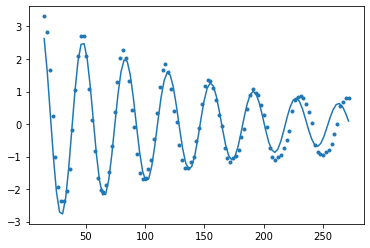

In [232]:
fig, ax = plt.subplots()
plt.scatter(df['time'], df['y_acc'], marker='.')
plt.plot(x, y)